# Exercise 1. Train a multilayer perceptron (MLP) network in numpy.

In this exercise, We implement training of a multilayer perceptron network using the `numpy` library.
* We implement forward and backward computations required for computing the gradients with backpropagation.
* We train an MLP on a toy data set.

We will implement an MLP with two hidden layers like shown in this figure:

<img src="mlp.png" width=300 style="float: top;">

We will build the following computational graph:

<img src="mlp_compgraph.png" width=600 style="float: top;">

Note that the computational graph contains a mean-squared error (MSE) loss because we solve a regression problem.

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Gradient of the loss

We start by implementing the last block of the computational graph which is the mean-squared error loss:
$$
c = \frac{1}{N n_y} \sum_{n=1}^{N} \sum_{i=1}^{n_y} \left(y_i^{(n)} - t_i^{(n)}\right)^2
$$
where
* $y_i^{(n)}$ is the $i$-th element of input example $\mathbf{y}^{(n)}$,
* $t_i^{(n)}$ is the $i$-th element of the corresponding target example $\mathbf{t}^{(n)}$,
* $n_y$ is the number of elements in $\mathbf{y}^{(n)}$,
* $N$ is the number of training examples.

In the code below, we define a class that performs forward and backward computations of this loss function. Your task is to implement the `backward` function which should compute the gradient $\frac{\partial c}{\partial \mathbf{y}}$.

Note that we process all $N$ training examples at the same time. Therefore, our implementation operates with two-dimensional arrays of shape `(n_samples, ysize)` where `n_samples` is the number $N$ of training samples and `ysize` is the number $n_y$ of elements in $\mathbf{y}$.

In [4]:
class MSELoss:
    def forward(self, y, target):
        """
        Args:
          y of shape (n_samples, ysize): Inputs of the loss function (can be, e.g., an output of a neural network).
          target of shape (n_samples, ysize): Targets.
        
        Returns:
          loss (float): The loss value.
        """
        self.diff = diff = y - target  # Keep this for backward computations
        c = np.sum(np.square(diff)) / diff.size
        return c

    def backward(self):
        """
        Returns:
          dy of shape (n_samples, ysize): Gradient of the MSE loss wrt the inputs.
        """
        assert hasattr(self, 'diff'), "Need to call forward() first"
        
        # Easy to get the formulation below using differential
        dy = (2 / self.diff.size) * self.diff
        return dy

## 2. Linear layer

Next we implement a linear layer.

The forward computations of the linear layer are
$$
\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}.
$$

In the backward pass, the linear layer receives the gradients wrt to the outputs $\frac{\partial c}{\partial \mathbf{y}}$ and it needs to compute:
* the gradients wrt the layer parameters $\mathbf{W}$ and $\mathbf{b}$
* the gradient $\frac{\partial c}{\partial \mathbf{x}}$ wrt the inputs.

In the cell below, we define a class that resembles class [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) of pytorch. It calls functions `linear_forward` and `linear_backward` that implement the forward and backward computations. We implmented it this way because it makes it easier to test `linear_forward` and `linear_backward`.

In [10]:
class Linear:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (int): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize the weights
        bound = 3 / np.sqrt(in_features)
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        bound = 1 / np.sqrt(in_features)
        self.b = np.random.uniform(-bound, bound, out_features)

        self.grad_W = None  # Attribute to store the gradients wrt W
        self.grad_b = None  # Attribute to store the gradients wrt b

    def forward(self, x):
        """
        Args:
          x of shape (n_samples, xsize): Inputs.
        
        Returns:
          y of shape (n_samples, ysize): Outputs.
        """
        self.x = x  # Keep this for backward computations
        return linear_forward(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
        """
        assert hasattr(self, 'x'), "Need to call forward() first"
        assert dy.ndim == 2 and dy.shape[1] == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward(dy, self.x, self.W, self.b)
        return dx

In [11]:
def linear_forward(x, W, b):
    """Forward computations in the linear layer:
        y = W x + b

    Args:
      x of shape (n_samples, xsize): Inputs.
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      y of shape (n_samples, ysize): Outputs.
    """

    y = np.dot(x, W.T) + b
    return y

    raise NotImplementedError()

    
def linear_backward(dy, x, W, b):
    """Backward computations in the linear layer.

    Args:
      dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
      x of shape (n_samples, xsize): Inputs.
      W of shape (ysize, xsize): Weight matrix.
      b of shape (ysize,): Bias term.

    Returns:
      dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
      dW of shape (ysize, xsize): Gradient wrt weight matrix W.
      db of shape (ysize,): Gradient wrt bias term b.
    """
    assert dy.ndim == 2 and dy.shape[1] == W.shape[0]

    # Easy to get this using differential
    dx = np.dot(dy, W)
    dW = np.dot(dy.T, x)
    db = np.sum(dy, axis=0)
    return dx, dW, db

## 3. The Tanh activation function

Next we implement the Tanh activation function. The activation function is applied *element-wise* to input vector $\mathbf{x}$ to produce outputs $\mathbf{y}$:
$$
\mathbf{y} = \text{tanh}(\mathbf{x}) \quad \text{such that} \quad y_i = \text{tanh}(x_i).
$$

When we backpropagate through that block, we need to transform the gradients $\frac{\partial c}{\partial \mathbf{y}}$ wrt to the outputs into the gradients wrt the inputs $\frac{\partial c}{\partial \mathbf{x}}$.
Notes:

In [6]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x of shape (n_features,): Inputs.
        
        Returns:
          y of shape (n_features,): Outputs.
        """

        self.x = x
        y = np.tanh(x)
        return y
    
        raise NotImplementedError()

    def backward(self, dy):
        """
        Args:
          dy of shape (n_features,): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_features,): Gradient of a loss wrt inputs.
        """
        assert hasattr(self, 'x'), "Need to call forward() first."

        dx = np.multiply(dy, 1 - np.tanh(self.x)**2)
        return dx

## 4. Multilayer Perceptron (MLP)

In the cell below, We implement an MLP with two hidden layers and `Tanh` nonlinearity. Use instances of classes `Linear` and `Tanh` in the above implementation.

In [7]:
class MLP:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """
        Args:
          in_features (int): Number of inputs which should be equal to xsize.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs which should be equal to ysize.
        """

        self.fc1 = Linear(in_features, hidden_size1)
        self.fn1 = Tanh()
        self.fc2 = Linear(hidden_size1, hidden_size2)
        self.fn2 = Tanh()       
        self.fc3 = Linear(hidden_size2, out_features)
                 
    def forward(self, x):
        """
        Args:
          x of shape (n_samples, xsize): Inputs.
        
        Returns:
          y of shape (n_samples, ysize): Outputs.
        """

        x = self.fc1.forward(x)
        x = self.fn1.forward(x)
        x = self.fc2.forward(x)
        x = self.fn2.forward(x)
        x = self.fc3.forward(x)
        
        return x
    
    def backward(self, dy):
        """
        Args:
          dy of shape (n_samples, ysize): Gradient of a loss wrt outputs.
        
        Returns:
          dx of shape (n_samples, xsize): Gradient of a loss wrt inputs.
        """

        dy = self.fc3.backward(dy)
        dy = self.fn2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.fn1.backward(dy)
        dy = self.fc1.backward(dy)
        
        return dy

## 5. Training MLP network with backpropagation

Now let us use our code to train an MLP network.

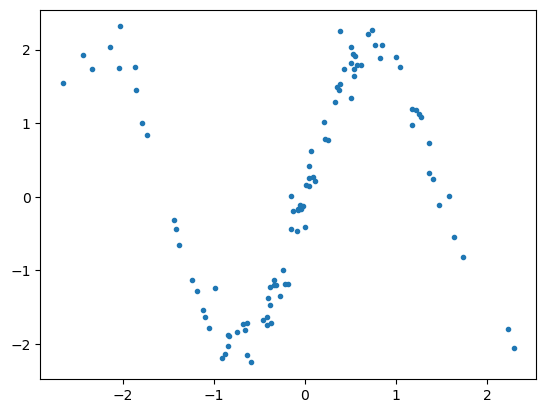

In [8]:
# Generate toy data
def get_data():
    np.random.seed(2)
    x = np.random.randn(100, 1)
    x = np.sort(x, axis=0)

    targets = 2 * np.sin(x * 2 * np.pi / 3)
    targets = targets + 0.2 * np.random.randn(*targets.shape)

    return x, targets

x, targets = get_data()
# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

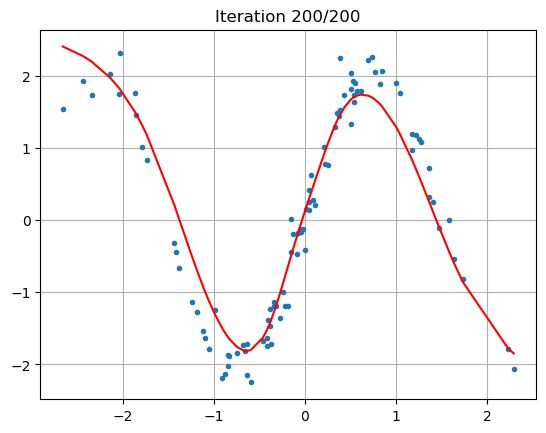

In [14]:
# And train an MLP network using gradient descent
from IPython import display

mlp = MLP(1, 10, 11, 1)  # Create MLP network
loss = MSELoss()  # Create loss

fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')
learning_rate = 0.05
n_epochs =  200
for i in range(n_epochs):
    # Forward computations
    y = mlp.forward(x)
    c = loss.forward(y, targets)

    # Backward computations
    dy = loss.backward()
    dx = mlp.backward(dy)

    # Gradient descent update
    #learning_rate *= 0.99  # Learning rate annealing
    for module in mlp.__dict__.values():
        if hasattr(module, 'W'):
            module.W = module.W - module.grad_W * learning_rate
            module.b = module.b - module.grad_b * learning_rate

    ax.clear()
    ax.plot(x, targets, '.')
    ax.plot(x, y, 'r-')
    ax.grid(True)
    ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.005)
display.clear_output(wait=True)